In [1]:
import keras
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.utils import get_source_inputs
from keras.utils import get_file
from keras.losses import categorical_crossentropy

from keras.models import Model
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers

from model import *
from train import *
from input_utils import *


In [10]:
import os

# Create the config
name = "exp-v0-2024-07-27"
description = """ """
C = Config(name, description)

if not os.path.exists(C.base_exp_path):
    os.mkdir(C.base_exp_path)

data_path = 'base_dataset/train'
annotation_filename =  'annotation.txt' # Training data (annotation file)

In [11]:
# from input_utils import *

import os
import cv2
import numpy as np

def get_data(annotation_filename, data_path):
    """Parse the data from annotation file

    Args:
        annotation_filename: annotation file path
        data_path: base directory with image files

    Returns:
        all_data: list(filepath, width, height, list(bboxes))
        classes_count: dict{key:class_name, value:count_num} 
            e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
        class_mapping: dict{key:class_name, value: idx}
            e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
    """
    found_bg = False
    all_imgs = {}

    classes_count = {}

    class_mapping = {}

    visualise = True

    i = 1

    annotation_filepath = os.path.join(data_path, annotation_filename)

    with open(annotation_filepath,'r') as f:

        print('Parsing annotation file')

        for line in f:

            # Print process
            print('\r'+'idx=' + str(i))
            i += 1

            line_split = line.strip().split(',')

            # Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
            # Note:
            #	One path_filename might has several classes (class_name)
            #	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
            #	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
            #   x1,y1-------------------
            #	|						|
            #	|						|
            #	|						|
            #	|						|
            #	---------------------x2,y2

            (filename,x1,y1,x2,y2,class_name) = line_split

            if class_name not in classes_count:
                classes_count[class_name] = 1
            else:
                classes_count[class_name] += 1

            if class_name not in class_mapping:
                if class_name == 'bg' and found_bg == False:
                    print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
                    found_bg = True
                class_mapping[class_name] = len(class_mapping)

            if filename not in all_imgs:
                all_imgs[filename] = {}
                
                filepath = os.path.join(data_path, filename + ".pgm")
                
                print(f"reading {filepath}")

                #img = cv2.imread(filepath)
                #filepath = "train/mdb001.pgm"
                img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                x, y = img.shape
                img = img.reshape(x, y, 1)
                (rows,cols) = img.shape[:2]
                all_imgs[filename]['filepath'] = filepath
                all_imgs[filename]['width'] = cols
                all_imgs[filename]['height'] = rows
                all_imgs[filename]['bboxes'] = []

            all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


        all_data = []
        for key in all_imgs:
            all_data.append(all_imgs[key])

        # make sure the bg class is last in the list
        if found_bg:
            if class_mapping['bg'] != len(class_mapping) - 1:
                key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
                val_to_switch = class_mapping['bg']
                class_mapping['bg'] = len(class_mapping) - 1
                class_mapping[key_to_switch] = val_to_switch

        if 'bg' not in classes_count:
            classes_count['bg'] = 0
            class_mapping['bg'] = len(class_mapping)

        return all_data, classes_count, class_mapping


st = time.time()
train_imgs, classes_count, class_mapping = get_data(annotation_filename, data_path)
C.class_mapping = class_mapping
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation file
idx=1
reading base_dataset/train\mdb001.pgm
idx=2
reading base_dataset/train\mdb002.pgm
idx=3
Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).
reading base_dataset/train\mdb003.pgm
idx=4
reading base_dataset/train\mdb005.pgm
idx=5
idx=6
reading base_dataset/train\mdb007.pgm
idx=7
reading base_dataset/train\mdb009.pgm
idx=8
reading base_dataset/train\mdb012.pgm
idx=9
reading base_dataset/train\mdb013.pgm
idx=10
reading base_dataset/train\mdb016.pgm
idx=11
reading base_dataset/train\mdb017.pgm
idx=12
reading base_dataset/train\mdb019.pgm
idx=13
reading base_dataset/train\mdb020.pgm
idx=14
reading base_dataset/train\mdb023.pgm
idx=15
reading base_dataset/train\mdb028.pgm
idx=16
reading base_dataset/train\mdb029.pgm
idx=17
reading base_dataset/train\mdb030.pgm
idx=18
reading base_dataset/train\mdb031.pgm
idx=19
reading base_dataset/train\mdb035.pgm
idx=20
reading base_dataset/train\mdb036.pgm
i

In [12]:
# if 'bg' not in classes_count:
#     classes_count['bg'] = 0
#     class_mapping['bg'] = len(class_mapping)

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(C.config_output_filename, 'wb') as config_f:
	pickle.dump(C,config_f)
	print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(C.config_output_filename))


Training images per class:
{'B': 47, 'M': 26, 'bg': 122}
Num classes (including bg) = 3
{'B': 0, 'bg': 2, 'M': 1}
Config has been written to exp-v0-2024-07-27\model_vgg_config.pickle, and can be loaded when testing to ensure correct results


In [15]:
C.class_mapping

{'B': 0, 'bg': 2, 'M': 1}

In [13]:
# Shuffle the images with seed
random.seed(1)
random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 190


In [14]:
# Get train data generator which generate X, Y, image_data
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')
# X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

Original image: height=1024 width=1024
Resized image:  height=300 width=300 C.im_size=300
Feature map size: height=18 width=18 C.rpn_stride=16
(1, 300, 300, 1)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 18, 18, 24)
Shape of y_rpn_regr (1, 18, 18, 96)
{'filepath': 'base_dataset/train\\mdb247.pgm', 'width': 1024, 'height': 1024, 'bboxes': [{'class': 'bg', 'x1': 0, 'x2': 1022, 'y1': 2, 'y2': 1024}]}
Number of positive anchors for this image: 0


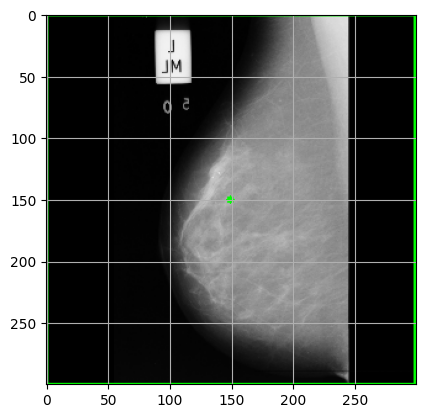

Green bboxes is ground-truth bbox. Others are positive anchors


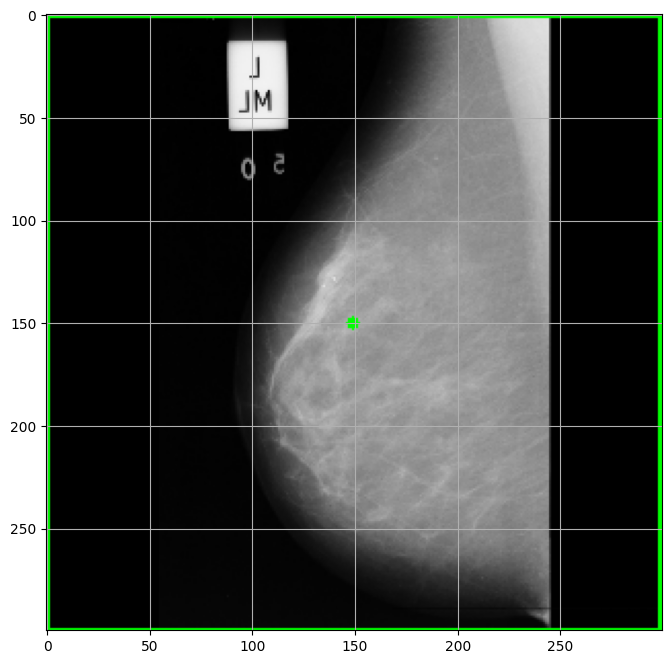

In [15]:
### Data exploration
X, Y, image_data, debug_img, debug_num_pos, debug_dict = next(data_gen_train)
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):

        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]

        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
#         cv2.putText(img, 'pos anchor bbox '+str(i+1), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8,8))
plt.grid()
plt.imshow(img)
plt.show()

In [16]:
### Build model
input_shape_img = (None, None, 1) # Changed from 3 to 1 channel

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)



# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9
rpn = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

# Because the google colab can only run the session several hours one time (then you need to connect again), 
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of your training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
            https://github.com/fchollet/keras/tree/master/keras/applications')
    
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    # Load the records
    record_df = pd.read_csv(C.record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))
    
    
# Model compilation
optimizer = Adam(learning_rate=1e-5) # changed from lr
optimizer_classifier = Adam(learning_rate=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

This is the first time of your training
Could not load pretrained model weights. Weights can be found in the keras application folder             https://github.com/fchollet/keras/tree/master/keras/applications


In [17]:
# Training setting
total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 1000
num_epochs = 40
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

In [18]:
start_time = time.time()
for epoch_num in range(num_epochs):

    progbar = keras.utils.Progbar(epoch_length)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
    
    r_epochs += 1

    while True:
        try:
#         if True:

            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
    #                 print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos, debug_dict = next(data_gen_train)
#             print(f"Debug processing {debug_dict}")

            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300) # TODO changed from image_dim_ordering

            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue

            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()

                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            # training_data: [X, X2[:, sel_samples, :]]
            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            #  X                     => img_data resized image
            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time()-start_time)/60

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)

                new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                           'class_acc':round(class_acc, 3), 
                           'loss_rpn_cls':round(loss_rpn_cls, 3), 
                           'loss_rpn_regr':round(loss_rpn_regr, 3), 
                           'loss_class_cls':round(loss_class_cls, 3), 
                           'loss_class_regr':round(loss_class_regr, 3), 
                           'curr_loss':round(curr_loss, 3), 
                           'elapsed_time':round(elapsed_time, 3), 
                           'mAP': 0}

                record_df = pd.concat([record_df, pd.DataFrame([new_row])], ignore_index=True)
                record_df.to_csv(C.record_path, index=0)

                break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue

print('Training complete, exiting.')

Epoch 1/40
 346/1000 [=========>....................] - ETA: 2:30 - rpn_cls: 1.1556 - rpn_regr: 0.1158 - final_cls: 0.2896 - final_regr: 0.0159Exception: 'a' cannot be empty unless no samples are taken
Exception: 'a' cannot be empty unless no samples are taken
 494/1000 [=============>................] - ETA: 2:39 - rpn_cls: 1.1490 - rpn_regr: 0.1240 - final_cls: 0.2535 - final_regr: 0.0160Exception: 'a' cannot be empty unless no samples are taken
Exception: 'a' cannot be empty unless no samples are taken
 613/1000 [=================>............] - ETA: 2:29 - rpn_cls: 1.2132 - rpn_regr: 0.1393 - final_cls: 0.2425 - final_regr: 0.0167Exception: 'a' cannot be empty unless no samples are taken
Exception: 'a' cannot be empty unless no samples are taken
 702/1000 [====================>.........] - ETA: 1:59 - rpn_cls: 1.2675 - rpn_regr: 0.1509 - final_cls: 0.2380 - final_regr: 0.0171Exception: 'a' cannot be empty unless no samples are taken


1000/1000 [==============================] - 368s 359ms/step - rpn_cls: 1.3638 - rpn_regr: 0.1734 - final_cls: 0.2241 - final_regr: 0.0174
Mean number of bounding boxes from RPN overlapping ground truth boxes: 0.05387931034482758
Classifier accuracy for bounding boxes from RPN: 0.9765
Loss RPN classifier: 1.473848247666019
Loss RPN regression: 0.20874079135432838
Loss Detector classifier: 0.17653094708443803
Loss Detector regression: 0.01691742604225874
Total loss: 1.8760374121470442
Elapsed time: 367.59213519096375
Total loss decreased from inf to 1.8760374121470442, saving weights
Epoch 2/40
   1/1000 [..............................] - ETA: 2:47 - rpn_cls: 0.0000e+00 - rpn_regr: 0.0000e+00 - final_cls: 1.1027e-05 - final_regr: 0.0000e+00

C:\Users\pawel\AppData\Local\Temp\ipykernel_39648\3068657771.py:148: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  record_df = pd.concat([record_df, pd.DataFrame([new_row])], ignore_index=True)


  18/1000 [..............................] - ETA: 4:00 - rpn_cls: 1.4154 - rpn_regr: 0.0316 - final_cls: 0.0224 - final_regr: 0.0000e+00Exception: 'a' cannot be empty unless no samples are taken
Exception: 'a' cannot be empty unless no samples are taken
 776/1000 [======================>.......] - ETA: 44s - rpn_cls: 0.8694 - rpn_regr: 0.1000 - final_cls: 0.0811 - final_regr: 0.0120Exception: 'a' cannot be empty unless no samples are taken
Exception: 'a' cannot be empty unless no samples are taken
 837/1000 [========================>.....] - ETA: 32s - rpn_cls: 0.8696 - rpn_regr: 0.1006 - final_cls: 0.0849 - final_regr: 0.0125Exception: 'a' cannot be empty unless no samples are taken


1000/1000 [==============================] - 194s 194ms/step - rpn_cls: 0.8647 - rpn_regr: 0.1015 - final_cls: 0.0937 - final_regr: 0.0139
Mean number of bounding boxes from RPN overlapping ground truth boxes: 0.15528455284552845
Classifier accuracy for bounding boxes from RPN: 0.97075
Loss RPN classifier: 0.8357831511746671
Loss RPN regression: 0.10694329884508624
Loss Detector classifier: 0.1440174006688714
Loss Detector regression: 0.02234299230785109
Total loss: 1.1090868429964758
Elapsed time: 194.3196198940277
Total loss decreased from 1.8760374121470442 to 1.1090868429964758, saving weights
Epoch 3/40
1000/1000 [==============================] - 178s 178ms/step - rpn_cls: 0.3549 - rpn_regr: 0.0931 - final_cls: 0.2384 - final_regr: 0.0399
Mean number of bounding boxes from RPN overlapping ground truth boxes: 0.31227106227106227
Classifier accuracy for bounding boxes from RPN: 0.9415
Loss RPN classifier: 0.36880479851557646
Loss RPN regression: 0.09783399122720585
Loss Detector cl

1000/1000 [==============================] - 178s 178ms/step - rpn_cls: 0.4281 - rpn_regr: 0.0965 - final_cls: 0.2020 - final_regr: 0.0351
Mean number of bounding boxes from RPN overlapping ground truth boxes: 0.34285714285714286
Classifier accuracy for bounding boxes from RPN: 0.933
Loss RPN classifier: 0.3744578336702369
Loss RPN regression: 0.09111219243472442
Loss Detector classifier: 0.2096181048720052
Loss Detector regression: 0.03784284555583872
Total loss: 0.7130309765328052
Elapsed time: 178.86977696418762
Total loss decreased from 0.7230428623000881 to 0.7130309765328052, saving weights
Epoch 5/40
  68/1000 [=>............................] - ETA: 2:53 - rpn_cls: 0.0674 - rpn_regr: 0.1265 - final_cls: 0.2607 - final_regr: 0.0806

KeyboardInterrupt: 

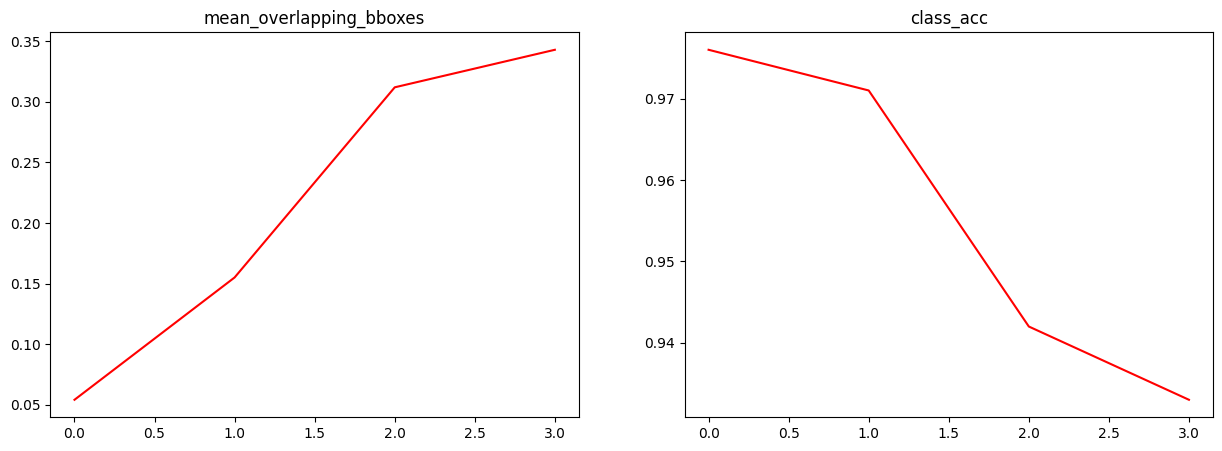

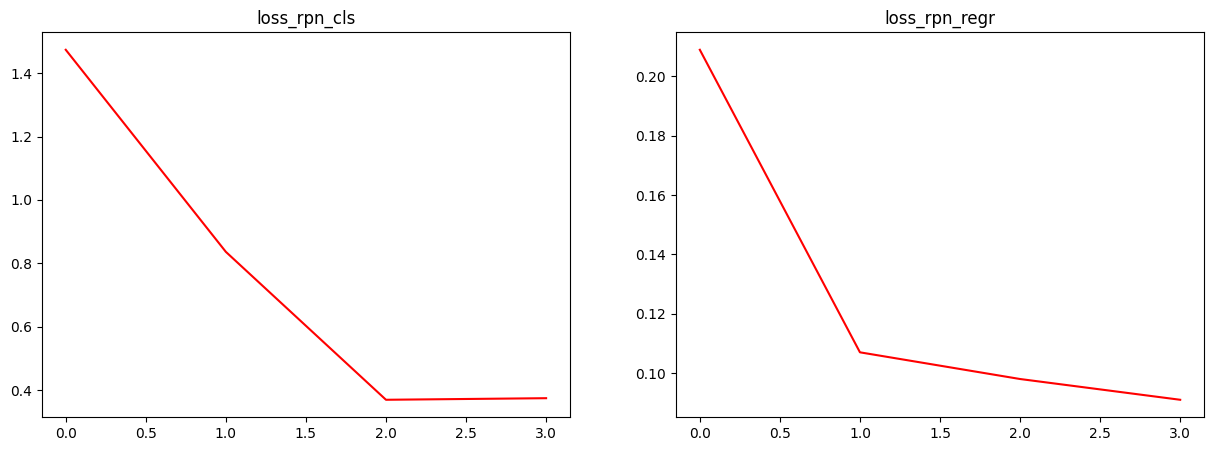

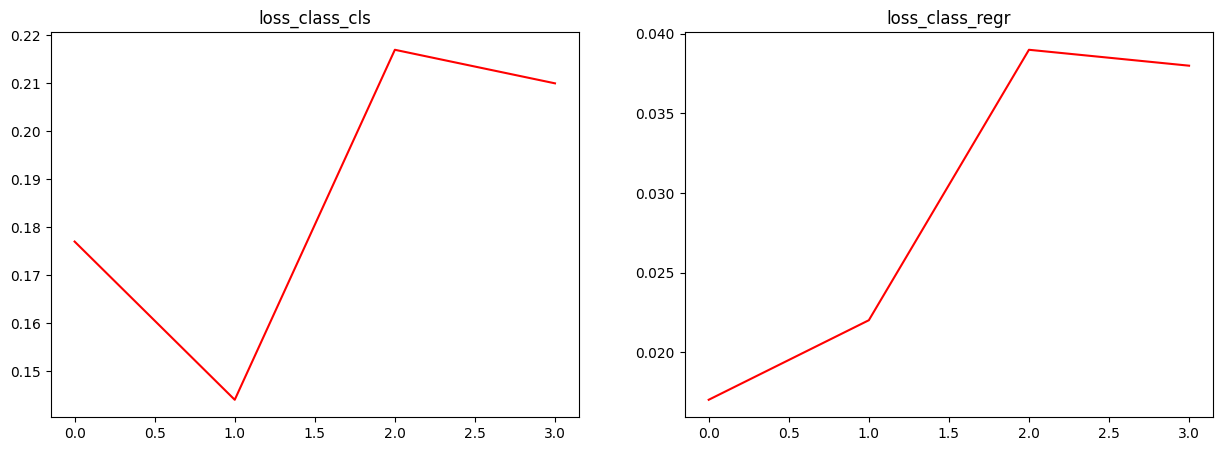

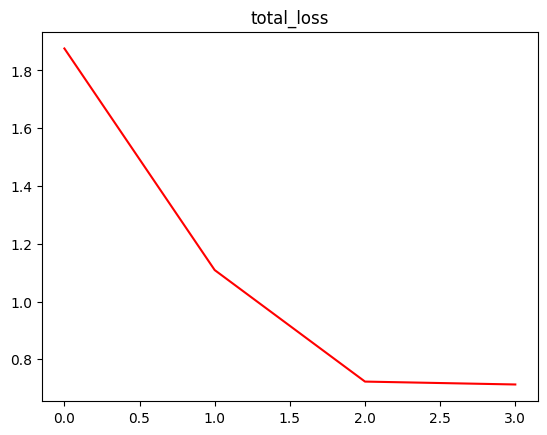

In [20]:
r_epochs = 40

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()

# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
# plt.title('total_loss')
# plt.subplot(1,2,2)
# plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
# plt.title('elapsed_time')
# plt.show()

# plt.title('loss')
# plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'b')
# plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'g')
# plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
# plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'c')
# # plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'm')
# plt.show()

In [21]:
record_df

,mean_overlapping_bboxes,class_acc,loss_rpn_cls,loss_rpn_regr,loss_class_cls,loss_class_regr,curr_loss,elapsed_time,mAP
0,0.054,0.976,1.474,0.209,0.177,0.017,1.876,6.127,0
1,0.155,0.971,0.836,0.107,0.144,0.022,1.109,3.239,0
2,0.312,0.942,0.369,0.098,0.217,0.039,0.723,2.985,0
3,0.343,0.933,0.374,0.091,0.210,0.038,0.713,2.981,0
